In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#we are going to use fastai.
#%pip install fastai==0.7.0

## Fraud Detection Zindi Project

By Atwine Mugume

Some of the resources used here include these articles that educate on imbalanced data

- [Dealing with Imbalanced Data](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)
- [Handling Imbalanced Datasets: Predicting Credit Card Fraud](https://medium.com/coinmonks/handling-imbalanced-datasets-predicting-credit-card-fraud-544f5e74e0fd)
- [Tackling Class Imbalance](https://www.kaggle.com/shahules/tackling-class-imbalance)  thanks to Shahules786's kernel
- [Great article on scaling data](https://www.kaggle.com/discdiver/guide-to-scaling-and-standardizing?source=post_page---------------------------)
-[performance-metrics-for-classification-problems](https://medium.com/thalus-ai/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b)


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

%time
print('Importing fastai libraries')
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

print('Done!')

['training.csv', 'test.csv', '.ipynb_checkpoints', 'Xente_Variable_Definitions.csv', 'fastai-xente-project-v.ipynb']
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.68 µs
Importing fastai libraries
Done!


In [4]:
#%pip install --upgrade numpy

In [5]:
#let's take a quick look at the data
#since we have a time variable we have to parse the dates
train = pd.read_csv('./training.csv', low_memory=True, 
                     parse_dates=["TransactionStartTime"])
test = pd.read_csv('./test.csv',low_memory=True, 
                     parse_dates=["TransactionStartTime"])

print('Done Readind the data!')

Done Readind the data!


In [6]:
#let's have a description of the variables here to keep refering to them
feature_desc = pd.read_csv('./Xente_Variable_Definitions.csv')
feature_desc

,Column Name,Definition
0,TransactionId,Unique �transaction identifier on platform
1,BatchId,Unique number assigned to a batch of transacti...
2,AccountId,Unique number identifying the customer on plat...
3,SubscriptionId,Unique number identifying the customer subscri...
4,CustomerId,Unique identifier attached to Account
5,CurrencyCode,Country currency
6,CountryCode,Numerical geographical code of country
7,ProviderId,Source provider of Item �bought.
8,ProductId,Item name being bought.
9,ProductCategory,ProductIds are organized into these broader pr...


In [7]:
#what does the data look like
train.shape,test.shape

((95662, 16), (45019, 15))

There are datasets which we have to look at carefully because they have a time variable. We have to make sure the time is progressive.
That is we are having the first rows from a time before those at the end of the dataset

For example if the first row is on the date 9/Jan/2019 the last row should not be the same date...it should be maybe 25/Oct/2021 so we can have a progression. 

Therefore our model will be used to tell the future.

In [8]:
#let's have a snippet of the head of the two datasets
train.head(5)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0


In [9]:
train.tail(5)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
95657,TransactionId_89881,BatchId_96668,AccountId_4841,SubscriptionId_3829,CustomerId_3078,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-1000.0,1000,2019-02-13 09:54:09+00:00,2,0
95658,TransactionId_91597,BatchId_3503,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2019-02-13 09:54:25+00:00,2,0
95659,TransactionId_82501,BatchId_118602,AccountId_4841,SubscriptionId_3829,CustomerId_3874,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2019-02-13 09:54:35+00:00,2,0
95660,TransactionId_136354,BatchId_70924,AccountId_1346,SubscriptionId_652,CustomerId_1709,UGX,256,ProviderId_6,ProductId_19,tv,ChannelId_3,3000.0,3000,2019-02-13 10:01:10+00:00,2,0
95661,TransactionId_35670,BatchId_29317,AccountId_4841,SubscriptionId_3829,CustomerId_1709,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13 10:01:28+00:00,2,0


In [10]:
#let's get snippet of the test data
test.head(5)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13 10:01:40+00:00,4
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13 10:02:12+00:00,2
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13 10:02:30+00:00,2
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13 10:02:38+00:00,4
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13 10:02:58+00:00,2


In [11]:
test.tail(5)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
45014,TransactionId_116198,BatchId_117348,AccountId_4841,SubscriptionId_3829,CustomerId_5225,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_3,-5000.0,5000,2019-03-14 23:56:28+00:00,2
45015,TransactionId_24829,BatchId_53630,AccountId_4803,SubscriptionId_1738,CustomerId_5272,UGX,256,ProviderId_3,ProductId_10,airtime,ChannelId_3,10000.0,10000,2019-03-14 23:57:38+00:00,1
45016,TransactionId_102920,BatchId_112209,AccountId_4817,SubscriptionId_4613,CustomerId_5286,UGX,256,ProviderId_3,ProductId_10,airtime,ChannelId_3,10000.0,10000,2019-03-14 23:59:17+00:00,1
45017,TransactionId_128439,BatchId_58734,AccountId_4841,SubscriptionId_3829,CustomerId_5286,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_3,-5000.0,5000,2019-03-14 23:59:39+00:00,2
45018,TransactionId_45927,BatchId_98308,AccountId_4593,SubscriptionId_3866,CustomerId_5057,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,3500.0,3500,2019-03-14 23:59:51+00:00,4


In [12]:
#Let's take a peek at the data into
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
TransactionId           95662 non-null object
BatchId                 95662 non-null object
AccountId               95662 non-null object
SubscriptionId          95662 non-null object
CustomerId              95662 non-null object
CurrencyCode            95662 non-null object
CountryCode             95662 non-null int64
ProviderId              95662 non-null object
ProductId               95662 non-null object
ProductCategory         95662 non-null object
ChannelId               95662 non-null object
Amount                  95662 non-null float64
Value                   95662 non-null int64
TransactionStartTime    95662 non-null datetime64[ns, UTC]
PricingStrategy         95662 non-null int64
FraudResult             95662 non-null int64
dtypes: datetime64[ns, UTC](1), float64(1), int64(4), object(10)
memory usage: 11.7+ MB


In [13]:
#Let's look at the shapes of the data
train.shape, test.shape

((95662, 16), (45019, 15))

## Initial Data Analysis

### Encoding

I have only discovered that the way you encode the data you have can affect how well your model will function. I have found some great resources here in these [article](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)

-This article is also a [good one](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159)

What stands out the most is these two points:

- Categorical features with large cardinalities/features (over 1000): `Binary Encoding` is ideal
- Categorical features with small cardinalities/features (less than 1000): `Numeric Encoding` is ideal

As an esample here is a code below from the library: binaryencoder

```python 
from category_encoders import *
import pandas as pd
from sklearn.datasets import load_boston

# prepare some data
bunch = load_boston()
y = bunch.target
X = pd.DataFrame(bunch.data, columns=bunch.feature_names)

# use binary encoding to encode two categorical features
enc = BinaryEncoder(cols=['CHAS', 'RAD']).fit(X)

# transform the dataset
numeric_dataset = enc.transform(X)


## A supervised example

from category_encoders import *
import pandas as pd
from sklearn.datasets import load_boston

# prepare some data
bunch = load_boston()
y_train = bunch.target[0:250]
y_test = bunch.target[250:506]
X_train = pd.DataFrame(bunch.data[0:250], columns=bunch.feature_names)
X_test = pd.DataFrame(bunch.data[250:506], columns=bunch.feature_names)

# use target encoding to encode two categorical features
enc = TargetEncoder(cols=['CHAS', 'RAD']).fit(X_train, y_train)

# transform the datasets
training_numeric_dataset = enc.transform(X_train, y_train)
testing_numeric_dataset = enc.transform(X_test)


```

In [14]:
#how unique is the batchId?
#i need to know if I should leave it in the conversation
for col in train.columns:
    print(col,'has', train[col].nunique())

TransactionId has 95662
BatchId has 94809
AccountId has 3633
SubscriptionId has 3627
CustomerId has 3742
CurrencyCode has 1
CountryCode has 1
ProviderId has 6
ProductId has 23
ProductCategory has 9
ChannelId has 4
Amount has 1676
Value has 1517
TransactionStartTime has 94556
PricingStrategy has 4
FraudResult has 2


In [14]:
#let's install the package with the encoders that make sense for this kind of data with only 10+ features
#%pip install category_encoders

## Lil Function

One fo the things I have learnt is to make code reusable, so I am going to write a function that will help us encode without having to repeat the code so much.

`Why is this function so important?`

I have been having memory issues wen I use the pd.getdummies. 
I normally have memory limited to 13Gb and as a result this method of replacing the categorical values with simple codes keeps the memory usage under 200Mbs. Which is quite phenomenal

In [15]:
#little function to help us encode data
def lil_encoder(df,col):
    df[col] = train[col].astype('category')
    
    #let's create a new column of the categorical features
    #df[col] = df[col].cat.codes
    
    return df.head(4)

In [16]:
#we need to keep the ids of the test data
fin_Id = test['TransactionId']
y = train['FraudResult']

#let's now drop them from their original datasets
test = test.drop(columns=['TransactionId'])
train = train.drop(columns=['FraudResult','TransactionId'])

In [17]:
#i want to see if the datasets are aligned, when they are not aligned one gets problems in fitting the data
train.shape, test.shape

((95662, 14), (45019, 14))

In [18]:
test.head(4)

,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13 10:01:40+00:00,4
1,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13 10:02:12+00:00,2
2,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13 10:02:30+00:00,2
3,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13 10:02:38+00:00,4


In [19]:
#let me put the datasets together so that I can work on them at the same time
train['Identifier']='Train'
test['Identifier']='Test'

ls = [train, test]
data = pd.concat(ls)
data.head(5)

,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,Identifier
0,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,Train
1,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,Train
2,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,Train
3,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,Train
4,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,Train


In [20]:
#let's encode all the data
ls_ = ['AccountId','CustomerId','ProviderId','ProductId','ProductCategory','ChannelId','BatchId','SubscriptionId']

#this is the for loop that calls the function and makes the lil_function work
for col in ls_:
    lil_encoder(data,col)

We now have all the columns in the list above transformed from object to categorical, now we are going to encode them with a categorical encoder. I have chosen to update my encoding method because of some of the articles I have read on this topic, they insist that we shd use Binary encoders for small datasets

In [21]:
from category_encoders import *

# use binary encoding to encode two categorical features
enc = BinaryEncoder(cols=['AccountId','CustomerId','ProviderId','ProductId','ProductCategory','ChannelId','BatchId','SubscriptionId']).fit(data)

data = enc.transform(data)


In [22]:
data.head(5)

,BatchId_0,BatchId_1,BatchId_2,BatchId_3,BatchId_4,BatchId_5,BatchId_6,BatchId_7,BatchId_8,BatchId_9,...,ProductCategory_3,ProductCategory_4,ChannelId_0,ChannelId_1,ChannelId_2,Amount,Value,TransactionStartTime,PricingStrategy,Identifier
0,0,0,1,0,1,1,0,1,1,1,...,0,1,0,1,1,1000.0,1000,2018-11-15 02:18:49+00:00,2,Train
1,0,0,0,1,1,1,1,1,0,0,...,1,1,0,1,0,-20.0,20,2018-11-15 02:19:08+00:00,2,Train
2,0,0,1,1,1,0,1,0,1,1,...,0,1,0,1,1,500.0,500,2018-11-15 02:44:21+00:00,2,Train
3,0,0,0,0,0,0,0,1,1,1,...,0,1,0,1,1,20000.0,21800,2018-11-15 03:32:55+00:00,2,Train
4,0,0,1,0,1,1,1,1,1,1,...,1,1,0,1,0,-644.0,644,2018-11-15 03:34:21+00:00,2,Train


In [23]:
#dropping some features: there are some features we can see that will not contribute to the ML process

#let's split the data
train = data[data['Identifier']=='Train']
test = data[data['Identifier']=='Test']

#now let's drop the useless columns from the datasets
train = train.drop(columns=['CurrencyCode','CountryCode','Amount'])
test = test.drop(columns=['CurrencyCode','CountryCode','Amount'])

#let's see the new shapes
train.shape, test.shape

((95662, 79), (45019, 79))

In [24]:
test.head(3)

,BatchId_0,BatchId_1,BatchId_2,BatchId_3,BatchId_4,BatchId_5,BatchId_6,BatchId_7,BatchId_8,BatchId_9,...,ProductCategory_2,ProductCategory_3,ProductCategory_4,ChannelId_0,ChannelId_1,ChannelId_2,Value,TransactionStartTime,PricingStrategy,Identifier
0,0,0,1,0,1,1,0,1,1,1,...,0,0,1,0,1,1,1000,2019-02-13 10:01:40+00:00,4,Test
1,0,0,0,1,1,1,1,1,0,0,...,0,1,1,0,1,0,2000,2019-02-13 10:02:12+00:00,2,Test
2,0,0,1,1,1,0,1,0,1,1,...,0,0,1,0,1,1,50,2019-02-13 10:02:30+00:00,2,Test


I have tried to load the date time function from fastai but it has failed so i am going to copy it manually and use it here.

In [25]:
def add_datepart(df, fldname, drop=True, time=False):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.

    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.

    Examples:
    ---------

    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df

        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13

    >>> add_datepart(df, 'A')
    >>> df

        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [26]:
#let's add the datetime variables
#this is a function in the fastai lib that deals with all variables of time, ie it converts the datatime column into many others
add_datepart(test,'TransactionStartTime')
add_datepart(train,'TransactionStartTime')

In [27]:
#let's have a look at the dataframe now and see how its looks like after we add the datetime variables
train.head(4)

,BatchId_0,BatchId_1,BatchId_2,BatchId_3,BatchId_4,BatchId_5,BatchId_6,BatchId_7,BatchId_8,BatchId_9,...,TransactionStartTimeDay,TransactionStartTimeDayofweek,TransactionStartTimeDayofyear,TransactionStartTimeIs_month_end,TransactionStartTimeIs_month_start,TransactionStartTimeIs_quarter_end,TransactionStartTimeIs_quarter_start,TransactionStartTimeIs_year_end,TransactionStartTimeIs_year_start,TransactionStartTimeElapsed
0,0,0,1,0,1,1,0,1,1,1,...,15,3,319,False,False,False,False,False,False,1542248329
1,0,0,0,1,1,1,1,1,0,0,...,15,3,319,False,False,False,False,False,False,1542248348
2,0,0,1,1,1,0,1,0,1,1,...,15,3,319,False,False,False,False,False,False,1542249861
3,0,0,0,0,0,0,0,1,1,1,...,15,3,319,False,False,False,False,False,False,1542252775


In [28]:
#let's remove the identifier columns so that we have only the features we need to use otherwise we will have problems.
train = train.drop(columns='Identifier')
test = test.drop(columns='Identifier')

In [29]:
train.head(4)

,BatchId_0,BatchId_1,BatchId_2,BatchId_3,BatchId_4,BatchId_5,BatchId_6,BatchId_7,BatchId_8,BatchId_9,...,TransactionStartTimeDay,TransactionStartTimeDayofweek,TransactionStartTimeDayofyear,TransactionStartTimeIs_month_end,TransactionStartTimeIs_month_start,TransactionStartTimeIs_quarter_end,TransactionStartTimeIs_quarter_start,TransactionStartTimeIs_year_end,TransactionStartTimeIs_year_start,TransactionStartTimeElapsed
0,0,0,1,0,1,1,0,1,1,1,...,15,3,319,False,False,False,False,False,False,1542248329
1,0,0,0,1,1,1,1,1,0,0,...,15,3,319,False,False,False,False,False,False,1542248348
2,0,0,1,1,1,0,1,0,1,1,...,15,3,319,False,False,False,False,False,False,1542249861
3,0,0,0,0,0,0,0,1,1,1,...,15,3,319,False,False,False,False,False,False,1542252775


In [30]:
#plot graph of feature importances for better visualization
#plt.figure(figsize=(7,7))
#feat_importances = pd.Series(rm_clf.feature_importances_, index=train.columns)
#feat_importances.nlargest(10).plot(kind='bar')
#plt.show()

In [30]:
#let's see the shapes of the data now
train.shape, test.shape

((95662, 90), (45019, 90))

In [31]:
#let's attach the y column to find correlations and after remove
train['FraudResult']= y
# Find correlations with the target and sort
correlations = train.corr()['FraudResult'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))


Most Positive Correlations:
 SubscriptionId_2     0.033930
ChannelId_2          0.034272
ProductId_3          0.035686
ProductId_5          0.045169
ProductId_4          0.049997
ProviderId_3         0.074962
Value                0.566739
FraudResult          1.000000
BatchId_0                 NaN
AccountId_0               NaN
SubscriptionId_0          NaN
CustomerId_0              NaN
ProviderId_0              NaN
ProductId_0               NaN
ProductCategory_0         NaN
Name: FraudResult, dtype: float64

Most Negative Correlations:
 ProviderId_1                    -0.083548
ProductId_1                     -0.049321
PricingStrategy                 -0.033821
SubscriptionId_1                -0.029144
SubscriptionId_4                -0.028527
AccountId_2                     -0.023884
AccountId_10                    -0.021586
CustomerId_7                    -0.014871
SubscriptionId_11               -0.010745
CustomerId_10                   -0.010288
CustomerId_2                    -0.01

In [32]:
#I really don't have much issue with correlation
y = train['FraudResult']
train = train.drop(columns='FraudResult')

## Creating a Validation set

We are going to take the last 20,000 values and keep them for validation. We want to use this information to make sure we are checkin properly if our models are doing well on out of sample data.

In [33]:
#lets first mix the train and lable
train['FraudResult']= y

#choose the last 20k rows to be kept aside
valid = train.tail(20000)

#bread the validation set into X and y
y_valid = valid['FraudResult']
X_valid = valid.drop(columns='FraudResult')

In [34]:
valid.head(4)

,BatchId_0,BatchId_1,BatchId_2,BatchId_3,BatchId_4,BatchId_5,BatchId_6,BatchId_7,BatchId_8,BatchId_9,...,TransactionStartTimeDayofweek,TransactionStartTimeDayofyear,TransactionStartTimeIs_month_end,TransactionStartTimeIs_month_start,TransactionStartTimeIs_quarter_end,TransactionStartTimeIs_quarter_start,TransactionStartTimeIs_year_end,TransactionStartTimeIs_year_start,TransactionStartTimeElapsed,FraudResult
75662,0,0,0,0,0,1,1,0,0,1,...,0,28,False,False,False,False,False,False,1548656268,0
75663,0,0,0,0,0,1,0,0,0,1,...,0,28,False,False,False,False,False,False,1548656287,0
75664,0,0,0,1,0,1,1,0,1,1,...,0,28,False,False,False,False,False,False,1548656326,0
75665,0,0,0,1,0,1,0,0,1,0,...,0,28,False,False,False,False,False,False,1548656337,0


In [35]:
valid.shape

(20000, 91)

In [36]:
'FraudResult' in X_valid.columns

False

In [37]:
#lets now take the ones for validation out of the major dataset

train  = train.iloc[0:75662, ]

y = train['FraudResult']
train = train.drop(columns='FraudResult')

In [38]:
train.shape, X_valid.shape


((75662, 90), (20000, 90))

### Imbalance in data:
There is a problem we have with the target variable, we have more of one result than the other, that is we have less fraud cases than the where there was actually fraud.

We have to handle this data in a different way.

Text(0.5, 1.0, 'Target variable count')

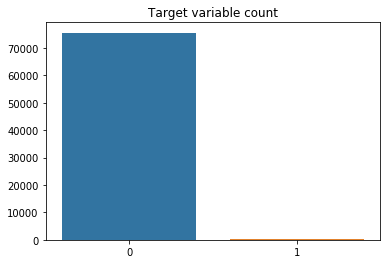

In [39]:
#i want to visualize the imbalance in the target variable
x=y.value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count')

## Smote: Oversampling data:

`SMOTE (Synthetic Minority Oversampling TEchnique)` consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

In [40]:
#First we are going to separate the target variable from the rest of the observations and split the data
from sklearn.model_selection import train_test_split

x = train

#split the data to prevent overfitting
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=1)

#let's see the shape of the data
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((60529, 90), (15133, 90), (60529,), (15133,))

In [41]:
#%pip install imblearn

In [42]:
#first we are going to filter out the different results from the label in the main label

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=27,ratio='minority')
X_train, y_train = smote.fit_sample(X_train, y_train)

In [43]:
#Let's see the shape
X_train.shape, y_train.shape

((120846, 90), (120846,))

In [44]:
#let's check and see the number of os and ones
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

After OverSampling, the shape of train_X: (120846, 90)
After OverSampling, the shape of train_y: (120846,) 

After OverSampling, counts of label '1': 60423
After OverSampling, counts of label '0': 60423


## Scaling the data

In [45]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
maxscaler = MinMaxScaler()

#let's scale the data with Standard Scaler
X_train = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)

#let's make all the data be in the range of 0-1 so the scales are balanced.
X_train = maxscaler.fit_transform(X_train)
X_test = maxscaler.fit_transform(X_test)

In [46]:
#now we have something to put in the model
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)
m.score(X_train, y_train)

/home/jupyter/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9999751750161362

## Feature Engineering

### Feature Importances and Selection

We want to know the best features in our model and how to harness them, this is important, and to find our more please read this [Article](https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e)

- What we want to do is use those features instead of the many useless, because I have noticed I get a good score on my F1 here but on the leader board it goes low, so I am overfitting

- [Great Article Here on Feature Selection and Importance methods](https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization)
- [Will Koerhsen on Feature Importances e.t.c](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
- [Manual Feature Engineering](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering)
- [Part Two of Feature Engineering](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2)

### Univariate feature selection and random forest classification

In [50]:
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import chi2
# find best scored 10 features
#select_feature = SelectKBest(chi2, k=10).fit(X_train, y_train)

In [51]:
#let's print the selected features
#print('Score list:', select_feature.scores_)

In [52]:
#let's take those features and transform the data we have
#x_train = select_feature.transform(X_train)
#x_test = select_feature.transform(X_test)

### Score Function

In [47]:
#I want to write a function that I will call to evaluate my model, I am going to evaluate based on ROC_AUC and score.

#when you build a model you want to know how it is functioning. And there are functions that are pre_built in scikit learn 
#to help you evaluate the model, so I built these in the functions below

def print_score(m,md):
    
    # Used to ignore warnings generated from StackingCVClassifier
    import warnings
    warnings.simplefilter('ignore')

    #Call the classification metrics we want to use
    from sklearn.metrics import roc_auc_score,auc,f1_score,roc_curve
    
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, m)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    f1 = f1_score(y_test,m)
    roc = roc_auc_score(y_test,m)
    #oob = md.oob_score_ #I added the oob score
    
    #let's see how the model does on validation data
    pred = md.predict(X_valid)
    f2 = f1_score(y_valid,pred)
    
    pred_3 = md.predict(X_train)
    f3 = f1_score(y_train,pred_3)
    
    res = ["roc_auc-->",roc_auc,"F1_score-->",f1,"roc_auc_score-->",roc]
    print(res)
    print('\n')
    
    print("Model Performance on out of sample data")
    
    valid = ['Valid_data_F1_score-->',f2]
    
    print(valid)
    
    print('\n')
    
    print("Model Performance on train data")
    
    train_ = ['Train_data_F1_score-->',f3]
    
    print(train_)
    
    
    print('\n')
    print('--'*10)
    print('Scores on the Validation Data according to the Confusion_matrix')
    
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_valid,pred).ravel()
    
    # Error rate : 
    err_rate = (fp + fn) / (tp + tn + fn + fp)
    print("Error rate  : ", err_rate)

    # Accuracy : 
    acc_ = (tp + tn) / (tp + tn + fn + fp)
    print("Accuracy  : ", acc_)
    
    
    #precision
    preci_ = tp / (tp + fp)
    print("Precision  : ", preci_)

    # Sensitivity : 
    sens_ = tp / (tp + fn)
    print("Recall  : ", sens_)

    # Specificity 
    sp_ = tn / (tn + fp)
    print("Specificity  : ", sens_)

    # False positive rate (FPR)
    FPR = fp / (tn + fp)
    print("False positive rate  : ", FPR)
    
    # False positive rate (FPR)
    TPR = tp / (tp + fn)
    print("True positive rate  : ", TPR)
    
    print('--'*10)
    
    
    print('\n')
    print('Drawing the Confusion Matrix on Out_of_sample_data')
    #from sklearn.metrics import confusion_matrix
    
    plt.figure(figsize=(7,7))
    cm_2 = confusion_matrix(y_valid,pred)
    sns.heatmap(cm_2,annot=True,fmt="d")
   

CPU times: user 2min 3s, sys: 12 ms, total: 2min 3s
Wall time: 17 s
['roc_auc-->', 0.9277773576344248, 'F1_score-->', 0.5714285714285714, 'roc_auc_score-->', 0.9277773576344248]


Model Performance on out of sample data
['Valid_data_F1_score-->', 0.003026951510565225]


Model Performance on train data
['Train_data_F1_score-->', 0.9998924277404033]


--------------------
Scores on the Validation Data according to the Confusion_matrix
Error rate  :  0.85635
Accuracy  :  0.14365
Precision  :  0.0015193128031321219
Recall  :  0.3939393939393939
Specificity  :  0.3939393939393939
False positive rate  :  0.8571786896759306
True positive rate  :  0.3939393939393939
--------------------


Drawing the Confusion Matrix on Out_of_sample_data


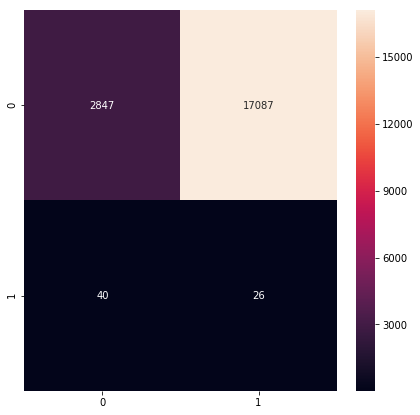

In [49]:
ml = RandomForestClassifier(n_jobs=-1, n_estimators=60, min_samples_leaf=3, max_features=0.5,bootstrap=True,oob_score =True)
%time ml.fit(X_train, y_train)
pred_d = ml.predict(X_test)
print_score(pred_d,ml)

## Feature Importances

```Python
#The difference between standard Pearson's correlation is that this one first transforms variables into ranks and only then runs Pearson's correlation on the ranks.

from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(X_train, figsize=(15,10))
viz.view()

#use this to overcome the bias in feature importances for all 


from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

```

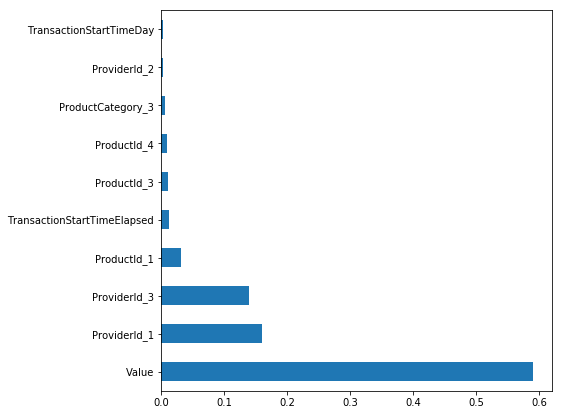

In [50]:
#plot graph of feature importances for better visualization
plt.figure(figsize=(7,7))
feat_importances = pd.Series(ml.feature_importances_, index=train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Feature Importances Study

I have been doing some study and I have found that using the default clasiffier feature importance maybe biased. There are other ways, I want to try them and see if I get the same results as the ones I get above.

In [53]:
#X_train_bi.shape, y_train_bi.shape

In [54]:
#I need to fit the new data and predict from that...

## Tuning Different Classifiers

I have got a high score by stacking up classifiers, these classifiers were not really tuned well enough to better their functionality.

My goal is to make better these classifiers and then stack them up again. The process involved takes a lot of time and computational space, to the extent that I can tune only about three models a day.

- [A great article on overfitting](https://medium.com/machine-learning-intuition/overfitting-what-they-are-regularization-e950c2d66d50)
- [Another article](https://www.gormanalysis.com/blog/magic-behind-constructing-a-decision-tree/)
- [A cook notebook to help](https://github.com/erykml/medium_articles/blob/master/feature_importance.ipynb)
- [OOB_Evaluation](http://cican17.com/machine-learning-with-tree-based-models-ii/)

In [51]:
#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#stack
#from mlxtend.classifier import StackingClassifier

#i will use this after the stack and see what happens
from sklearn.ensemble import AdaBoostClassifier

# Used to ignore warnings generated from StackingCVClassifier
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc


## Random Forest Classifier Tunning

When you tune a model you need to know how the model is doig and in order to find that out you have to evaluate the model, this can be based on which model you have because different models have different evaluations.
- [This article explain it well](https://towardsdatascience.com/common-classification-model-evaluation-metrics-2ba0a7a7436e)
- [Article 2](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234)
-[Ada Boost Article](https://www.datacamp.com/community/tutorials/adaboost-classifier-python)

-This article on Cross Validation is great, take some time to read it: It mentions the different types of Cross Validation for better understanding.[Cross Validation](https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f)

Articles on RForestClassifier
-[Article One] (https://chrisalbon.com/machine_learning/trees_and_forests/random_forest_classifier_example/)
-[Article Two]()


In [52]:
''''rm_clf = RandomForestClassifier()


# Define parameter grid 
params = {
    #'C' :list(range(2,15))
    #'kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    #'degree' : list(range(2,20)),
    #'gamma' : ['rbf', 'poly' ,'sigmoid','auto'],
    #'probability' : [False,True]
    
   'n_estimators':[147],
    'criterion':['entropy'],
    #'max_features':['auto','sqrt','log2','None'],
    #'min_samples_leaf': list(range(10,200))
}


# Initialize GridSearchCV
grid = GridSearchCV(estimator = rm_clf, 
                    param_grid = params, 
                    cv = 3,
                    scoring = "roc_auc",
                    verbose = 1,
                    n_jobs = -1)

# Fit GridSearchCV
%time
grid.fit(X_train, y_train)


y_pred = grid.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
f1 = f1_score(y_test,y_pred)

# Print results
print(f"The ROC of the tuned classifier is {roc_auc:.3f}")
print(f"The F1 of the tuned classifier is {f1:.3f}")

print(grid.best_params_)'''

'\'rm_clf = RandomForestClassifier()\n\n\n# Define parameter grid \nparams = {\n    #\'C\' :list(range(2,15))\n    #\'kernel\':[\'linear\', \'poly\', \'rbf\', \'sigmoid\', \'precomputed\'],\n    #\'degree\' : list(range(2,20)),\n    #\'gamma\' : [\'rbf\', \'poly\' ,\'sigmoid\',\'auto\'],\n    #\'probability\' : [False,True]\n    \n   \'n_estimators\':[147],\n    \'criterion\':[\'entropy\'],\n    #\'max_features\':[\'auto\',\'sqrt\',\'log2\',\'None\'],\n    #\'min_samples_leaf\': list(range(10,200))\n}\n\n\n# Initialize GridSearchCV\ngrid = GridSearchCV(estimator = rm_clf, \n                    param_grid = params, \n                    cv = 3,\n                    scoring = "roc_auc",\n                    verbose = 1,\n                    n_jobs = -1)\n\n# Fit GridSearchCV\n%time\ngrid.fit(X_train, y_train)\n\n\ny_pred = grid.predict(X_test)\n\nfalse_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)\nroc_auc = auc(false_positive_rate, true_positive_rate)\nf1 = f

In [53]:
#grid.best_params_

### Randomized Search

I want to compare the two search algorithms and see the one that does the best.

- I  have read that the randomize search can do the same work that the GridSearch can but in a shorter period of time and time is one thing I would like to save.

I have been having some hard time implementing the grid search algo, I have borrowed some ideas from Koerhsen on handing this in a good way. Let's implement them here.

## Frome here ***Research

To implement this I have decided to try using the LGBClassifier first.

Here below is a function that is borrowed from fastai that is going to help us samplea number of rows so we can do rapid prototyping

In [54]:
def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.

    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.

    Returns:
    --------
    return value: A random sample of n rows of df.

    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    >>> get_sample(df, 2)
       col1 col2
    1     2    b
    2     3    a
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [59]:
#we now take samples of the whole dataset without replacing
X_train_sample = get_sample(pd.DataFrame(X_train), 15000)
y_train_sample = get_sample(pd.DataFrame(y_train), 15000)

In [69]:
#%pip install setuptools wheel numpy scipy scikit-learn -U
#%pip install lightgbm

In [60]:
#let's have a look at the hyper parameters
from sklearn.model_selection import cross_val_score

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold

from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

model = lgb.LGBMClassifier()


In [61]:
#list of 
model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [62]:

# Hyperparameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

# Subsampling (only applicable with 'goss')
subsample_dist = list(np.linspace(0.5, 1, 100))

In [63]:
#since we will have many spaces to sample from let's subset the hyper parameters and work with a few at a time
import random

params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.7333333333333333,
 'learning_rate': 0.01814047354852268,
 'min_child_samples': 70,
 'num_leaves': 104,
 'reg_alpha': 0.4081632653061224,
 'reg_lambda': 0.7959183673469387,
 'subsample_for_bin': 240000}

In [64]:
params['subsample'] = random.sample(subsample_dist, 1)[0] if params['boosting_type'] != 'goss' else 1.0
params

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.7333333333333333,
 'learning_rate': 0.01814047354852268,
 'min_child_samples': 70,
 'num_leaves': 104,
 'reg_alpha': 0.4081632653061224,
 'reg_lambda': 0.7959183673469387,
 'subsample': 0.5151515151515151,
 'subsample_for_bin': 240000}

In [65]:
# Create a lgb dataset
train_set = lgb.Dataset(X_train_sample, label = y_train_sample)

In [66]:
# Perform cross validation with 10 folds
r = lgb.cv(params, train_set, num_boost_round = 10000, nfold = 10, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 50)

# Highest score
r_best = np.max(r['auc-mean'])

# Standard deviation of best score
r_best_std = r['auc-stdv'][np.argmax(r['auc-mean'])]

print('The maximium ROC AUC on the validation set was {:.5f} with std of {:.5f}.'.format(r_best, r_best_std))
print('The ideal number of iterations was {}.'.format(np.argmax(r['auc-mean']) + 1))

The maximium ROC AUC on the validation set was 0.99803 with std of 0.00120.
The ideal number of iterations was 28.


In [67]:
MAX_EVALS = 10
N_FOLDS = 5

# Dataframe to hold cv results
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))

In [68]:
def random_objective(params, iteration, n_folds = N_FOLDS):
    """Random search objective function. Takes in hyperparameters
       and returns a list of results to be saved."""

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    end = timer()
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    
    # Return list of results
    return [loss, params, iteration, n_estimators, end - start]

In [69]:
%%capture

random.seed(50)

# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    print(params)
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]
        
        
    results_list = random_objective(params, i)
    
    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

In [70]:
# Sort results by best validation score
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results.head()

,loss,params,iteration,estimators,time
0,0.00127925,"{'reg_lambda': 0.3469387755102041, 'subsample_...",5,465,713.923
1,0.00135814,"{'reg_lambda': 0.8163265306122448, 'subsample_...",6,1573,711.426
2,0.0013786,"{'reg_lambda': 0.3469387755102041, 'subsample_...",0,4894,637.141
3,0.00144347,"{'reg_lambda': 0.8979591836734693, 'subsample_...",4,2880,655.919
4,0.00150414,"{'reg_lambda': 0.6938775510204082, 'subsample_...",9,314,6.60128


In [79]:
random_results.loc[0, 'params']

{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 0.7333333333333333,
 'learning_rate': 0.14451322534564692,
 'min_child_samples': 280,
 'num_leaves': 117,
 'reg_alpha': 0.16326530612244897,
 'reg_lambda': 0.3469387755102041,
 'subsample': 0.9494949494949496,
 'subsample_for_bin': 200000}

Random and grid search are uninformed methods that do not use the past history, but we still need the history so we can find out which hyperparameters worked the best!

A dataframe is a useful data structure to hold the results.

In [52]:
MAX_EVALS = 100
N_FOLDS = 5

# Dataframes for random and grid search
random_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

In [79]:
import itertools

def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

In [100]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = cross_val_score(rm_clf, X_train,y_train, cv=5)
    
    # results to retun
    score = [cv_results]
    estimators = len(cv_results)
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [101]:
from sklearn.model_selection import GridSearchCV



grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## To here **Research
I want to rewrite the functions above by example so that I can implement cross validation well on the classifiers I want to use.

In [74]:
""""from sklearn.model_selection import GridSearchCV , RandomSearchCV
rm_clf = RandomForestClassifier()


# Define parameter grid 
params = {
    #'C' : [1,5,9,10,11,15,18,20,25,28,30,35,36,40,47,48,55,60,63,65,70,75,80,81,84,85,90,95,100],
    #'kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    #'degree' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    #'gamma' : ['rbf', 'poly' ,'sigmoid','auto'],
    #'probability' : [False,True]
    
   'n_estimators':list(range(300, 800)),
    #'max_depth' : [25, 30,35,40,45,50,60,100],
    #'min_samples_split' : [2, 3, 4, 5, 6, 7,8, 10],
    #'criterion':['entropy'],
    #'max_features':['auto'],
    #'min_samples_leaf': list(range(9,16)),
    #'bootstrap':[True],
    #'oob_score':[True]
}


# Initialize GridSearchCV
grid = RandomSearchCV(estimator = rm_clf, 
                    param_grid = params, 
                    cv = 3,
                    scoring = "f1",
                    verbose = 2,
                    n_iter=4,
                    n_jobs = -1)

# Fit GridSearchCV
%time
grid.fit(X_train, y_train)


y_pred = grid.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


# Print results
print("The ROC of the tuned classifier is",roc_auc)


print(grid.best_params_)"""

'"from sklearn.model_selection import GridSearchCV , RandomSearchCV\nrm_clf = RandomForestClassifier()\n\n\n# Define parameter grid \nparams = {\n    #\'C\' : [1,5,9,10,11,15,18,20,25,28,30,35,36,40,47,48,55,60,63,65,70,75,80,81,84,85,90,95,100],\n    #\'kernel\':[\'linear\', \'poly\', \'rbf\', \'sigmoid\', \'precomputed\'],\n    #\'degree\' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],\n    #\'gamma\' : [\'rbf\', \'poly\' ,\'sigmoid\',\'auto\'],\n    #\'probability\' : [False,True]\n    \n   \'n_estimators\':list(range(300, 800)),\n    #\'max_depth\' : [25, 30,35,40,45,50,60,100],\n    #\'min_samples_split\' : [2, 3, 4, 5, 6, 7,8, 10],\n    #\'criterion\':[\'entropy\'],\n    #\'max_features\':[\'auto\'],\n    #\'min_samples_leaf\': list(range(9,16)),\n    #\'bootstrap\':[True],\n    #\'oob_score\':[True]\n}\n\n\n# Initialize GridSearchCV\ngrid = RandomSearchCV(estimator = rm_clf, \n                    param_grid = params, \n                    cv = 3,\n                    scor

['roc_auc-->', 0.809259119211475, 'F1_score-->', 0.6190476190476191, 'roc_auc_score-->', 0.809259119211475]


Model Performance on out of sample data
['Valid_data_F1_score-->', 0.0]


Model Performance on train data
['Train_data_F1_score-->', 1.0]


--------------------
Scores on the Validation Data according to the Confusion_matrix
Error rate  :  0.00355
Accuracy  :  0.99645
Precision  :  0.0
Recall  :  0.0
Specificity  :  0.0
False positive rate  :  0.0002508277315139962
True positive rate  :  0.0
--------------------


Drawing the Confusion Matrix on Out_of_sample_data


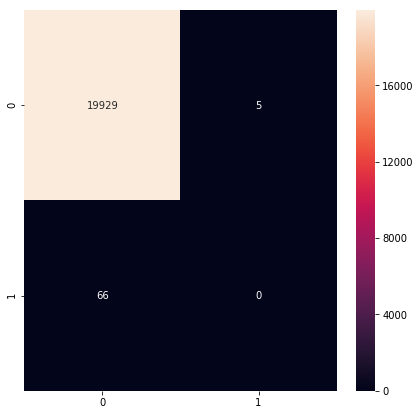

In [73]:
latest = RandomForestClassifier(n_estimators= 1000)#, min_samples_leaf= 9, min_samples_split=2, max_depth=25, max_features='auto', criterion= 'entropy',bootstrap=True,oob_score =True)
latest.fit(X_train, y_train)
pred_latest = latest.predict(X_test)
print_score(pred_latest,latest)

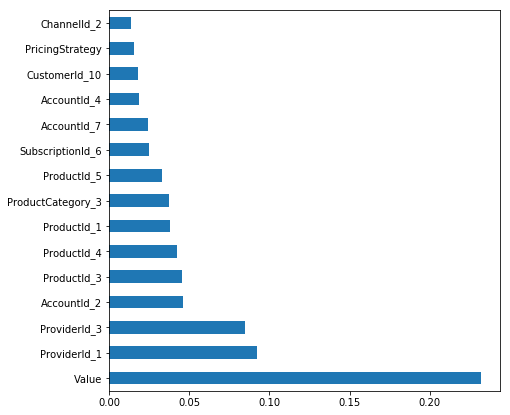

In [53]:
#let's see the feature importances
plt.figure(figsize=(7,7))
feat_importances = pd.Series(latest.feature_importances_, index=train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [54]:
feat_importances.nlargest(15)

Value                0.231963
ProviderId_1         0.092479
ProviderId_3         0.084861
AccountId_2          0.046184
ProductId_3          0.045509
ProductId_4          0.042175
ProductId_1          0.038053
ProductCategory_3    0.037571
ProductId_5          0.033220
SubscriptionId_6     0.024726
AccountId_7          0.024056
AccountId_4          0.018465
CustomerId_10        0.018218
PricingStrategy      0.015821
ChannelId_2          0.013839
dtype: float64

We are going to modify the X_train set and X_test test to make sure we get out only the useful features and work with those.

### Important Features

Let's use the most important features in the model and see if our scores increase

This [Link](https://chrisalbon.com/machine_learning/trees_and_forests/feature_selection_using_random_forest/) is very important to read for this part it helps you see how to do the feature selection

- [Another Article](https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f)

In [55]:
#let's use the most important features
from sklearn.feature_selection import SelectFromModel

#identify the features that have importance more than
sfm = SelectFromModel(latest)


In [56]:
# Train the selector
sfm.fit(X_train, y_train)


SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='entropy',
                                                 max_depth=25,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=9,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=300, n_jobs=None,
                                                 oob_score=True,
                                                 random_state=None, verbose=0,
  

In [57]:
#we find the threshold to use when choosing out features
sfm.threshold_

0.011111111111111112

In [58]:
#get the features in the data that fit this threshold
xfm = SelectFromModel(latest,threshold = 0.011)

xfm.fit_transform(X_train, y_train)

array([[1.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 1.     , ..., 1.     , 0.00023, 1.     ],
       [1.     , 0.     , 0.     , ..., 0.     , 0.     , 0.5    ],
       ...,
       [0.     , 1.     , 1.     , ..., 1.     , 0.05814, 0.39237],
       [0.     , 1.     , 1.     , ..., 1.     , 0.05814, 0.24197],
       [0.46698, 0.53302, 0.46698, ..., 1.     , 0.05814, 0.5    ]])

In [59]:
#print the features with the most importance
feat_labels = [col for col in train.columns]

for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

AccountId_2
AccountId_4
AccountId_7
SubscriptionId_6
CustomerId_2
CustomerId_10
ProviderId_1
ProviderId_3
ProductId_1
ProductId_3
ProductId_4
ProductId_5
ProductCategory_3
Value
PricingStrategy


In [60]:
#let's put the most important fetures into a new data set
X_imp_train = xfm.transform(X_train)
X_imp_test = xfm.transform(X_test)

X_imp_train.shape, X_imp_test.shape

((120846, 16), (15133, 16))

In [61]:
pd.DataFrame(X_imp_train).head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000002,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.000232,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000004,0.5
3,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.000116,0.5


In [62]:
#now let's run it with the best features only
latest_c = RandomForestClassifier(n_estimators= 1000,n_jobs=-1,bootstrap=True )

#fit the model
latest_c.fit(X_imp_train, y_train)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [63]:
#predict from the model
pred_latest = latest_c.predict(X_imp_test)

#print the score with the scoring function.
print_score(pred_latest,latest_c)

ValueError: Number of features of the model must match the input. Model n_features is 16 and input n_features is 90 

In [60]:
#bst_params = grid.best_params_
#bst_params

In [61]:
#test_2 = select_feature.transform(test)
#pred_new_2 = rm_clf_new.predict(test_2)

These are the best parameters after the recent run of RandomSearchCV
{'n_estimators': 215,
 'min_samples_leaf': 25,
 'max_features': 'sqrt',
 'criterion': 'entropy'}

In [62]:
#the functional Classifier
#rm_clf = RandomForestClassifier( n_estimators=64,max_depth =10,min_samples_split=0.2,min_samples_leaf=0.1,max_features=14)
#knn_clf = KNeighborsClassifier(n_neighbors=5,algorithm='auto')
#lgs_cls = LogisticRegression(penalty='l2', dual=True, max_iter=30)#87%
#gsn_cls= GaussianNB(priors=None, var_smoothing=1e-09)
#svc_cls= SVC()
#ada_cls= AdaBoostClassifier(n_estimators=10,learning_rate=1,algorithm='SAMME.R') #this takes a base estimator and corrects its issues

![](http://)### Feature Importance for Random Forest  Classifier

- I want to know which of the features are affecting the model in a good way and which ones are not important at all. 
- When I find the important ones I remove the 0: importance features and then work with those that are important. 
- I will use the classifier to help me make these decisions.

In [63]:
#fin_pred = rm_clf.predict(test)

In [64]:
""""Sub = pd.DataFrame({
    'TransactionId':fin_Id,
    'FraudResult':pred_new_2
})'''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-64-8cf861e71257>, line 4)

In [65]:
#Sub.to_csv('EnsembleTrain_3.csv',index=False)

### Subset the Data

For rapid prototyping of the models, we are going to chop the data into small bits so that we can do it quickly

In [63]:
#X__train = X_train[:40000,]
#y__train = y_train[:40000]
#X__test = X_test[:40000,]
#y__test = y_test[:40000]

### KNeighbour Classifier

In [ ]:
""""from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV 
rm_clf = KNeighborsClassifier()


# Define parameter grid 
params = {
    
    'n_neighbors':list(range(1,6)),
    #'weights':['uniform','distance'],
    #'algorithm':['auto','ball_tree','kd_tree','brute'],
    'leaf_size':list(range(1,7)),
    #'p':[1,2,3,4,5],
    'metric':['minkowski'],
    'metric_params':[None],
    'n_jobs':[-1],
    
}


# Initialize GridSearchCV
grid = GridSearchCV(estimator = rm_clf, 
                    param_grid = params, 
                    cv = 3,
                    scoring = "f1",
                    verbose = 1,
                    #n_iter=20,
                    n_jobs = -1)

# Fit GridSearchCV
%time
grid.fit(X__train, y__train)


y_pred = grid.predict(X__test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y__test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


# Print results
print("The ROC of the tuned classifier is", roc_auc)


print(grid.best_params_)"""

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


['roc_auc-->', 0.8544534145050291, 'F1_score-->', 0.009457329430308489, 'roc_auc_score-->', 0.8544534145050291]


Model Performance on out of sample data
['Valid_data_F1_score-->', 0.0]


Model Performance on train data
['Train_data_F1_score-->', 1.0]


--------------------
Scores on the Validation Data according to the Confusion_matrix
Error rate  :  0.0033
Accuracy  :  0.9967
Precision  :  nan
Sensitivity  :  0.0
Specificity  :  0.0
False positive rate  :  0.0
True positive rate  :  0.0
--------------------


Drawing the Confusion Matrix on Out_of_sample_data


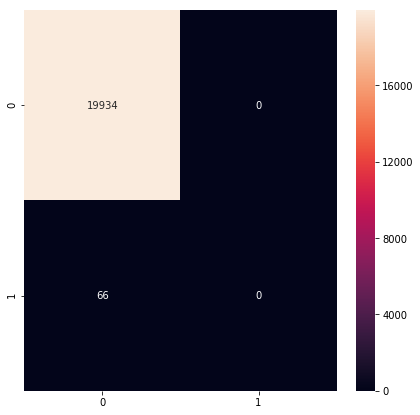

In [68]:
""""kn_1 = KNeighborsClassifier(weights='distance', p=5, n_neighbors=5, n_jobs=-1, metric_params=None, metric= 'minkowski', leaf_size= 3, algorithm= 'auto')
kn_1.fit(X_train, y_train)
pred_kn = kn_1.predict(X_test)
print_score(pred_kn,kn_1)"""